# Category Classification

In [6]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 32
max_length = 128
num_epochs = 20
learning_rate = 3e-4

Using device: cuda


In [8]:
# Load dataset
df = pd.read_csv(r"C:\Users\Jim\Jupiter Projects\CSE-498R\cholito_bengali_human_ai_dataset.csv")

# Merge categories: group 'story' and 'novel' into 'story_novel'
df = df[df['category'].isin(['poems', 'stories', 'essays', 'novels'])]  # filter to relevant categories

# Create new unified category column
df['merged_category'] = df['category'].replace({
    'stories': 'story_novel',
    'novels': 'story_novel',
    'essays': 'essay',
    'poems': 'poem'
})

# Map to numerical labels
label_map = {'story_novel': 0, 'essay': 1, 'poem': 2}
df['label'] = df['merged_category'].map(label_map)

# ✅ Balance the dataset
min_count = df['merged_category'].value_counts().min()
balanced_df = pd.concat([
    df[df['merged_category'] == category].sample(min_count, random_state=42)
    for category in ['story_novel', 'essay', 'poem']
])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract balanced texts and labels
texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

# ✅ Stratified split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# ✅ Check distribution
from collections import Counter

def print_distribution(labels, name):
    counts = Counter(labels)
    print(f"{name} set distribution:")
    for k, v in sorted(counts.items()):
        print(f"  Class {k}: {v}")
    print()

print_distribution(train_labels, "Train")
print_distribution(val_labels, "Validation")
print_distribution(test_labels, "Test")


Train set distribution:
  Class 0: 3200
  Class 1: 3200
  Class 2: 3200

Validation set distribution:
  Class 0: 400
  Class 1: 400
  Class 2: 400

Test set distribution:
  Class 0: 400
  Class 1: 400
  Class 2: 400



Total category distribution:
 category
novels     5000
essays     5000
stories    5000
poems      4000
Name: count, dtype: int64


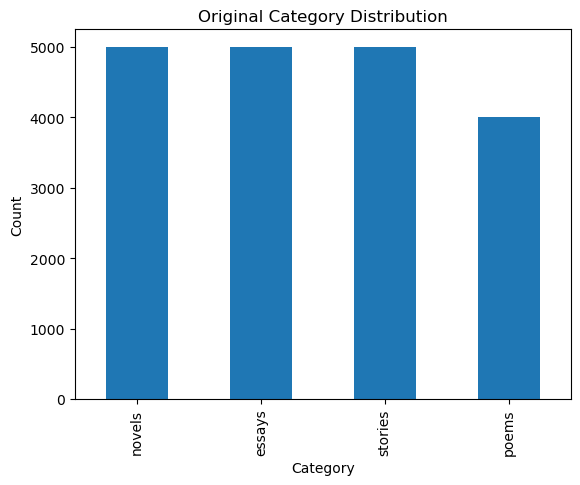

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

# Check category distribution in full dataset (before merge)
category_counts = df['category'].value_counts()
print("Total category distribution:\n", category_counts)

# Plot original categories
category_counts.plot(kind='bar', title='Original Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Train set distribution:
  Class 0: 3200
  Class 1: 3200
  Class 2: 3200

Validation set distribution:
  Class 0: 400
  Class 1: 400
  Class 2: 400

Test set distribution:
  Class 0: 400
  Class 1: 400
  Class 2: 400



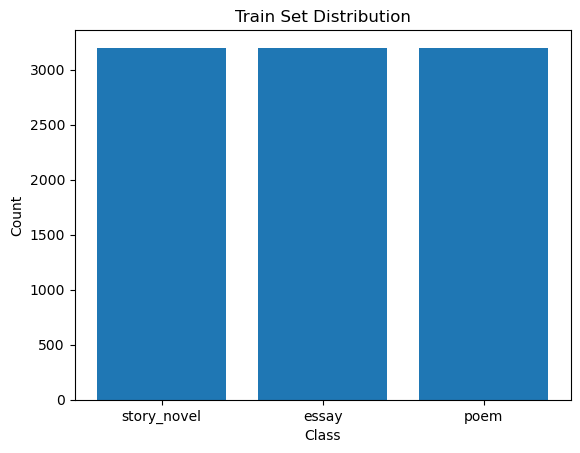

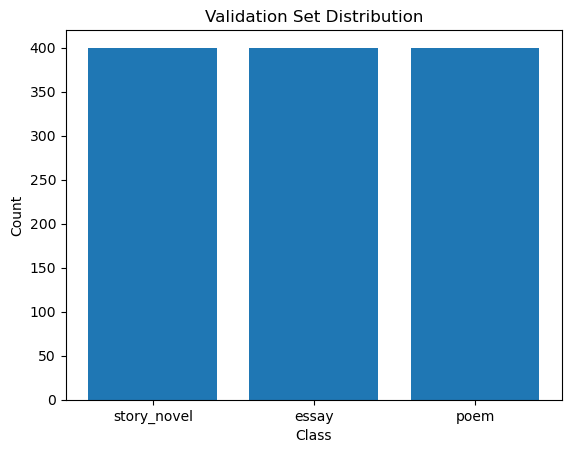

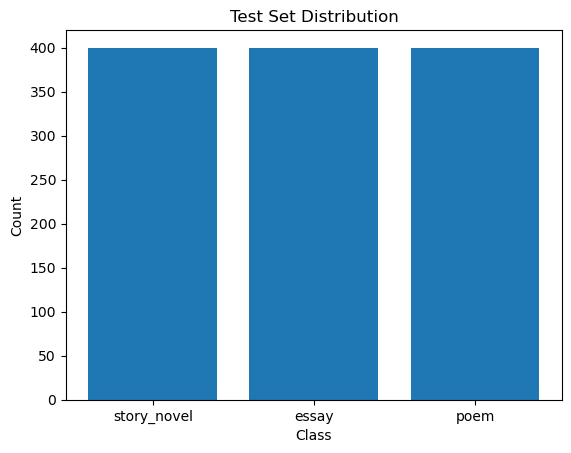

In [10]:
# Print label distributions
def print_distribution(labels, name):
    counts = Counter(labels)
    print(f"{name} set distribution:")
    for k, v in sorted(counts.items()):
        print(f"  Class {k}: {v}")
    print()

print_distribution(train_labels, "Train")
print_distribution(val_labels, "Validation")
print_distribution(test_labels, "Test")

# Plot label distributions with correct label names
def plot_distribution(labels, name):
    counts = Counter(labels)
    plt.bar(counts.keys(), counts.values())
    plt.title(f"{name} Set Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=[0, 1, 2], labels=['story_novel', 'essay', 'poem'])
    plt.show()

plot_distribution(train_labels, "Train")
plot_distribution(val_labels, "Validation")
plot_distribution(test_labels, "Test")

# Tokenizer

In [11]:
if not os.path.exists("bengali_tokenizer"):
    os.makedirs("bengali_tokenizer")  # Ensure the directory exists
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
    tokenizer.save_model("bengali_tokenizer")
else:
    tokenizer = ByteLevelBPETokenizer("bengali_tokenizer/vocab.json", "bengali_tokenizer/merges.txt")

def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids))
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids), torch.tensor(attention_masks)

class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attention_mask = encode_batch(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

train_dataset = BengaliTextDataset(train_texts, train_labels)
val_dataset = BengaliTextDataset(val_texts, val_labels)
test_dataset = BengaliTextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Custom Class

In [3]:
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)


# Training Setup

In [12]:
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size, num_classes=3).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Scheduler (optional warmup + decay)
from transformers import get_cosine_schedule_with_warmup
warmup_steps = 500
total_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)


In [13]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
print(f"Total Trainable Parameters: {count_trainable_parameters(model):,}")


Total Trainable Parameters: 26,976,259


In [14]:
def count_all_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total:,}")
    print(f"Trainable Parameters: {trainable:,}")
    print(f"Non-trainable Parameters: {total - trainable:,}")

# Usage:
count_all_parameters(model)


Total Parameters: 26,976,259
Trainable Parameters: 26,976,259
Non-trainable Parameters: 0


In [43]:
def train_epoch():
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(loader), accuracy, all_preds, all_labels

# Training

In [44]:
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch()
    val_loss, val_acc, _, _ = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save model if it improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), "best_3classification_category_bengali_transformer.pt")
        print("Saved new best model.")



Epoch 1/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 46.68it/s]


Train Loss: 0.9041, Val Loss: 0.7556, Val Acc: 0.7550
Saved new best model.

Epoch 2/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 48.63it/s]


Train Loss: 0.6951, Val Loss: 0.6546, Val Acc: 0.8083
Saved new best model.

Epoch 3/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.28it/s]


Train Loss: 0.6458, Val Loss: 0.6755, Val Acc: 0.8292
Saved new best model.

Epoch 4/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.87it/s]


Train Loss: 0.5913, Val Loss: 0.7457, Val Acc: 0.8117

Epoch 5/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 48.96it/s]


Train Loss: 0.5556, Val Loss: 0.6664, Val Acc: 0.8367
Saved new best model.

Epoch 6/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.47it/s]


Train Loss: 0.5205, Val Loss: 0.6635, Val Acc: 0.8400
Saved new best model.

Epoch 7/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.70it/s]


Train Loss: 0.5095, Val Loss: 0.7362, Val Acc: 0.8208

Epoch 8/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.84it/s]


Train Loss: 0.4784, Val Loss: 0.7557, Val Acc: 0.8033

Epoch 9/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.79it/s]


Train Loss: 0.4731, Val Loss: 0.7128, Val Acc: 0.8475
Saved new best model.

Epoch 10/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.89it/s]


Train Loss: 0.4485, Val Loss: 0.7335, Val Acc: 0.8233

Epoch 11/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 50.01it/s]


Train Loss: 0.4311, Val Loss: 0.7034, Val Acc: 0.8350

Epoch 12/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.77it/s]


Train Loss: 0.4081, Val Loss: 0.7894, Val Acc: 0.8250

Epoch 13/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 50.33it/s]


Train Loss: 0.3892, Val Loss: 0.7490, Val Acc: 0.8400

Epoch 14/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.94it/s]


Train Loss: 0.3788, Val Loss: 0.7359, Val Acc: 0.8383

Epoch 15/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.55it/s]


Train Loss: 0.3709, Val Loss: 0.7554, Val Acc: 0.8375

Epoch 16/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 47.94it/s]


Train Loss: 0.3624, Val Loss: 0.7558, Val Acc: 0.8442

Epoch 17/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.60it/s]


Train Loss: 0.3608, Val Loss: 0.7667, Val Acc: 0.8375

Epoch 18/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 48.95it/s]


Train Loss: 0.3577, Val Loss: 0.7536, Val Acc: 0.8417

Epoch 19/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 47.36it/s]


Train Loss: 0.3571, Val Loss: 0.7545, Val Acc: 0.8408

Epoch 20/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49.28it/s]

Train Loss: 0.3547, Val Loss: 0.7560, Val Acc: 0.8400


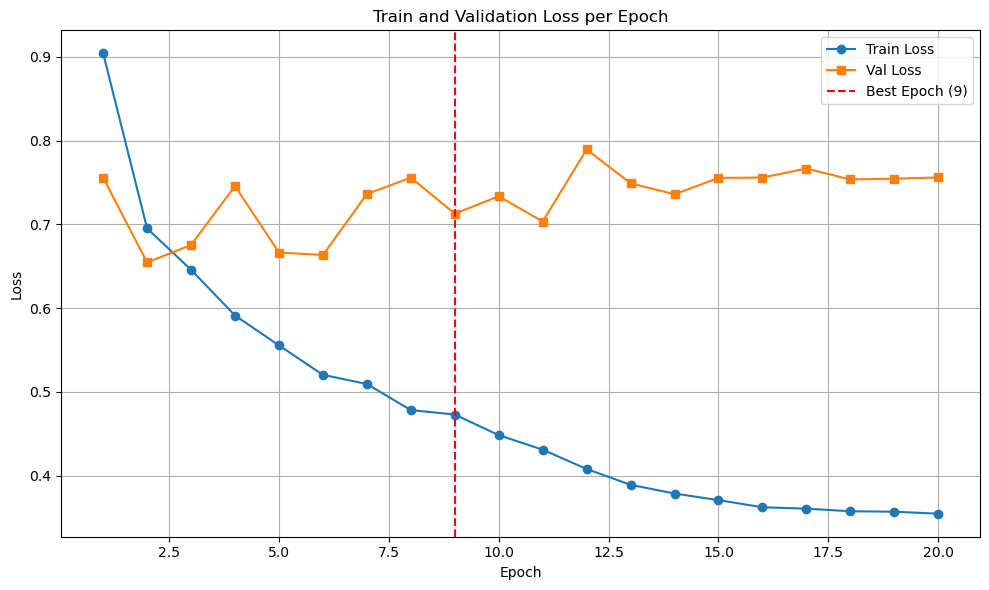

In [45]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='s')
plt.axvline(x=best_epoch + 1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch + 1})')

plt.title("Train and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
import torch

# Load best model weights
model.load_state_dict(torch.load("best_3classification_category_bengali_transformer.pt"))
model.eval()

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 48.95it/s]

Test Loss: 0.6925, Test Accuracy: 0.8492


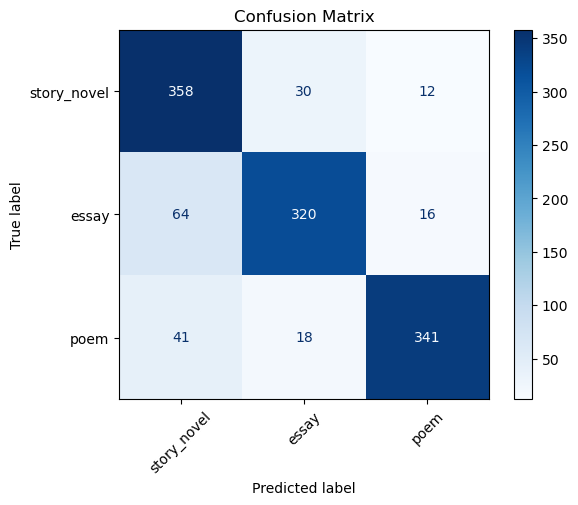

Classification Report:
              precision    recall  f1-score   support

 story_novel     0.7732    0.8950    0.8297       400
       essay     0.8696    0.8000    0.8333       400
        poem     0.9241    0.8525    0.8869       400

    accuracy                         0.8492      1200
   macro avg     0.8556    0.8492    0.8500      1200
weighted avg     0.8556    0.8492    0.8500      1200



In [47]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert predictions and labels to numpy arrays (if not already)
test_preds = test_preds.cpu().numpy() if hasattr(test_preds, "cpu") else test_preds
test_labels = test_labels.cpu().numpy() if hasattr(test_labels, "cpu") else test_labels

# Define correct class names
class_names = ["story_novel", "essay", "poem"]  # Corresponds to label_map: 0, 1, 2

# Plot confusion matrix with labels
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Print classification report with label names
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))
